# Predictive Maintenance in Jet Engines

Oh oh! There can be no more important application of predictive maintenance than for jet engines. For you to have peace when flying, those engines better not be failing anytime soon. Predictive maintenance tries to balance the cost of failures against the cost of maintenance. 

## Contents
- [The Use Case](#The-Use-Case)
- [Success Criteria](#Success-Criteria)
- [AI Solutions](#AI-Solutions)
    - [LSTM](#LSTM)
    - [Denoising](#Denoising)
- [Thoughts](#Thoughts)

## The Use Case

If an airline company does daily maintenance of their plane engines they will soon go bankrupt. Same applies if they never do any maintenance. Their planes may cause fatal accidents result in them going out of business. So the question is, what is the right amout of scheduled maintenance? 


![optimize](images/optimize.jpg)

The ability to predict Remaining Useful Life (RUL) enables the optimization of maintenance costs. However, this requires a robust IoT strategy to collect indicators of failure from the jet engines. Even with good data collection strategy, events like engine failures rarely occur. Simulations can help generate training data as what [NASA did](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

## Success Criteria

A success predictive maintenance model should be able to operate at the optimal point of the trade-off between the maintenance costs and downtime costs. Since the model will be predicting RUL, metrics to optimize are the Mean Squared Error (MSE). 

The predictive maintenance use case is interesting in the sense that the symmetry of the MSE function may not reflect what we want to happen in real life. The cost of overpredicting by one day vs underpredicting by one day when a failure occurs is enormously different. Therefore we would want to punish overpredictions more because they are way way too costly!

One way to achieve this is through the use of an asymmetric error function. We will not be covering asymmetric error functions but it's as straight forward as writing our own function similar to MSE and pass it to our model.

## AI Solution

For problems like these you may start with simple algorithms like regression, regressive decision trees and boosted trees, or time series forecasting algorithms like AR, ARMA, ARIMA, etc. I will not be going through these simple algorithms here but a quick internet search will show how these algorithms, though not the right tools, can be applied to a problems of predictive maintanance.

Since we are veterans at predictive maintenance we are going to jump straight into Long-Short Term Memory (LSTM) neural networks. Why LSTMs? The problem of predictive maintanance seeks to predict RUL. From our training data we cannot rely on measurements taken on one timestep. We need a few number of timesteps to predict RUL with reasonable accuracy.

![nonsymetric](images/nonsymetric.jpg)

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.grid'] = False

In [2]:
print("TF Version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TF Version:  2.8.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# os[n] is the n-th operating setting whilst ms[n] is the n-th sensor measurement

names = ["unit", "time","os1", "os2", "os3"] + ["ms{}".format(ms) for ms in range(1,22)]
names

['unit',
 'time',
 'os1',
 'os2',
 'os3',
 'ms1',
 'ms2',
 'ms3',
 'ms4',
 'ms5',
 'ms6',
 'ms7',
 'ms8',
 'ms9',
 'ms10',
 'ms11',
 'ms12',
 'ms13',
 'ms14',
 'ms15',
 'ms16',
 'ms17',
 'ms18',
 'ms19',
 'ms20',
 'ms21']

The input are 4 files. File 1 and 3 have simulations done at sea level conditions while file 2 and 4 have non-sea level conditions. File 1 and 2 experience the HPC degradation fault mode whilst file 3 and 4 experience 2 fault modes of HPC degradation and fan degradation. 

In [53]:
train_dataframe1 = pd.read_csv("data/train_FD001.txt", sep=" ", names=names, index_col=False) 
train_dataframe2 = pd.read_csv("data/train_FD002.txt", sep=" ", names=names, index_col=False) 
train_dataframe3 = pd.read_csv("data/train_FD003.txt", sep=" ", names=names, index_col=False) 
train_dataframe4 = pd.read_csv("data/train_FD004.txt", sep=" ", names=names, index_col=False) 

In [54]:
test_dataframe1 = pd.read_csv("data/test_FD001.txt", sep=" ", names=names, index_col=False) 
test_dataframe2 = pd.read_csv("data/test_FD002.txt", sep=" ", names=names, index_col=False) 
test_dataframe3 = pd.read_csv("data/test_FD003.txt", sep=" ", names=names, index_col=False) 
test_dataframe4 = pd.read_csv("data/test_FD004.txt", sep=" ", names=names, index_col=False) 

In [55]:
test_label1 = pd.read_csv("data/RUL_FD001.txt", sep=" ", names=['rul'], index_col=False) 
test_label2 = pd.read_csv("data/RUL_FD002.txt", sep=" ", names=['rul'], index_col=False) 
test_label3 = pd.read_csv("data/RUL_FD003.txt", sep=" ", names=['rul'], index_col=False) 
test_label4 = pd.read_csv("data/RUL_FD004.txt", sep=" ", names=['rul'], index_col=False) 

In [56]:
test_label1['unit'] = test_label1.index + 1
test_label2['unit'] = test_label2.index + 1
test_label3['unit'] = test_label3.index + 1
test_label4['unit'] = test_label4.index + 1

In [100]:
# Categorical features

# Each file corresponds to a different condition. ONE is for sea level and SIX is probably for about sea level
train_dataframe1["conditions"] = "ONE"
train_dataframe2["conditions"] = "SIX"
train_dataframe3["conditions"] = "ONE"
train_dataframe4["conditions"] = "SIX"

test_dataframe1["conditions"] = "ONE"
test_dataframe2["conditions"] = "SIX"
test_dataframe3["conditions"] = "ONE"
test_dataframe4["conditions"] = "SIX"

test_label1["conditions"] = "ONE"
test_label2["conditions"] = "SIX"
test_label3["conditions"] = "ONE"
test_label4["conditions"] = "SIX"

#The failure modes are difficult to have an attribute for as file 3 and 4 have 2 failure modes
train_dataframe1["file"] = 1
train_dataframe2["file"] = 2
train_dataframe3["file"] = 3
train_dataframe4["file"] = 4

test_dataframe1["file"] = 1
test_dataframe2["file"] = 2
test_dataframe3["file"] = 3
test_dataframe4["file"] = 4

test_label1["file"] = 1
test_label2["file"] = 2
test_label3["file"] = 3
test_label4["file"] = 4

train_df = pd.concat([train_dataframe1, train_dataframe2, train_dataframe3, train_dataframe4])
test_df = pd.concat([test_dataframe1, test_dataframe2, test_dataframe3, test_dataframe4])
label_df = pd.concat([test_label1, test_label2, test_label3, test_label4])

In [101]:
train_df

,unit,time,os1,os2,os3,ms1,ms2,ms3,ms4,ms5,...,ms14,ms15,ms16,ms17,ms18,ms19,ms20,ms21,conditions,file
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,ONE,1
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,ONE,1
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,ONE,1
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,ONE,1
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,ONE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,SIX,4
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,SIX,4
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,SIX,4
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,SIX,4


In [102]:
useful_lives = train_df.groupby(['file', 'unit']).size().reset_index(name='ul')

In [103]:
train_df = pd.merge(train_df, useful_lives, how='left', on=['file','unit'])

In [104]:
train_df['rul'] = train_df['ul'] - train_df['time']

In [105]:
train_df.drop(columns=['ul'], inplace=True)

In [106]:
train_df

,unit,time,os1,os2,os3,ms1,ms2,ms3,ms4,ms5,...,ms15,ms16,ms17,ms18,ms19,ms20,ms21,conditions,file,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,ONE,1,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,ONE,1,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,ONE,1,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,ONE,1,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,ONE,1,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8.4541,0.03,372,2319,100.0,29.11,17.5234,SIX,4,4
160355,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8.2221,0.03,396,2388,100.0,39.38,23.7151,SIX,4,3
160356,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8.2525,0.03,395,2388,100.0,39.78,23.8270,SIX,4,2
160357,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,9.0515,0.02,337,2223,100.0,15.26,9.0774,SIX,4,1


In [107]:
measurements_by_unit = train_df.groupby(['file', 'unit']).size().reset_index(name='measurements')
measurements_by_unit

,file,unit,measurements
0,1,1,192
1,1,2,287
2,1,3,179
3,1,4,189
4,1,5,269
...,...,...,...
704,4,245,205
705,4,246,161
706,4,247,211
707,4,248,184


In [108]:
units = train_df.groupby(['file'])['unit'].nunique().reset_index(name='units')
units

,file,units
0,1,100
1,2,260
2,3,100
3,4,249


In [109]:
min_measurements_by_unit = measurements_by_unit.groupby(['file'])['measurements'].min().reset_index(name='min_measurements')
min_measurements_by_unit

,file,min_measurements
0,1,128
1,2,128
2,3,145
3,4,128


In [110]:
test_df[(test_df['unit']==1) & (test_df['file']==1)]

,unit,time,os1,os2,os3,ms1,ms2,ms3,ms4,ms5,...,ms14,ms15,ms16,ms17,ms18,ms19,ms20,ms21,conditions,file
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,ONE,1
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,ONE,1
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,ONE,1
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,ONE,1
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,ONE,1
5,1,6,0.0012,0.0003,100.0,518.67,642.11,1579.12,1395.13,14.62,...,8127.46,8.4238,0.03,392,2388,100.0,38.91,23.3467,ONE,1
6,1,7,-0.0000,0.0002,100.0,518.67,642.11,1583.34,1404.84,14.62,...,8134.97,8.3914,0.03,391,2388,100.0,38.85,23.3952,ONE,1
7,1,8,0.0006,-0.0000,100.0,518.67,642.54,1580.89,1400.89,14.62,...,8125.93,8.4213,0.03,393,2388,100.0,39.05,23.3224,ONE,1
8,1,9,-0.0036,0.0000,100.0,518.67,641.88,1593.29,1412.28,14.62,...,8134.15,8.4353,0.03,391,2388,100.0,39.10,23.4521,ONE,1
9,1,10,-0.0025,-0.0001,100.0,518.67,642.07,1585.25,1398.64,14.62,...,8134.08,8.4093,0.03,391,2388,100.0,38.87,23.3820,ONE,1


In [111]:
test_useful_lives = test_df.groupby(['file', 'unit']).size().reset_index(name='ul')
test_useful_lives

,file,unit,ul
0,1,1,31
1,1,2,49
2,1,3,126
3,1,4,106
4,1,5,98
...,...,...,...
702,4,244,184
703,4,245,63
704,4,246,29
705,4,247,94


In [112]:
labeled_test_df = pd.merge(test_df, test_useful_lives, how='left', on=['file','unit'])

In [113]:
labeled_test_df

,unit,time,os1,os2,os3,ms1,ms2,ms3,ms4,ms5,...,ms15,ms16,ms17,ms18,ms19,ms20,ms21,conditions,file,ul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,ONE,1,31
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,ONE,1,31
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,ONE,1,31
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,ONE,1,31
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,ONE,1,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104892,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,9.4427,0.02,331,2212,100.0,10.53,6.2620,SIX,4,281
104893,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,9.2772,0.02,366,2324,100.0,24.33,14.6486,SIX,4,281
104894,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,9.3982,0.02,336,2223,100.0,14.69,8.8389,SIX,4,281
104895,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,9.2727,0.03,366,2324,100.0,24.44,14.6887,SIX,4,281


In [114]:
labeled_test_df['dummy_rul'] = labeled_test_df['ul'] - labeled_test_df['time']

In [115]:
labeled_test_df = pd.merge(labeled_test_df, label_df, how='left', on=['file','unit'])

In [116]:
labeled_test_df['rul'] = labeled_test_df['ul'] + labeled_test_df['dummy_rul']

In [117]:
labeled_test_df.drop(columns=['ul','dummy_rul','conditions_y'], inplace=True)
labeled_test_df.rename(columns={'conditions_x':'conditions'}, inplace=True)

In [118]:
labeled_test_df

,unit,time,os1,os2,os3,ms1,ms2,ms3,ms4,ms5,...,ms15,ms16,ms17,ms18,ms19,ms20,ms21,conditions,file,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8.4052,0.03,392,2388,100.0,38.86,23.3735,ONE,1,61
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8.3803,0.03,393,2388,100.0,39.02,23.3916,ONE,1,60
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8.4441,0.03,393,2388,100.0,39.08,23.4166,ONE,1,59
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8.3917,0.03,391,2388,100.0,39.00,23.3737,ONE,1,58
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8.4031,0.03,390,2388,100.0,38.99,23.4130,ONE,1,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104892,248,277,41.9991,0.8401,100.0,445.00,550.30,1364.40,1129.17,3.91,...,9.4427,0.02,331,2212,100.0,10.53,6.2620,SIX,4,285
104893,248,278,20.0026,0.7005,100.0,491.19,608.00,1494.75,1260.88,9.35,...,9.2772,0.02,366,2324,100.0,24.33,14.6486,SIX,4,284
104894,248,279,34.9988,0.8413,100.0,449.44,555.92,1370.65,1130.97,5.48,...,9.3982,0.02,336,2223,100.0,14.69,8.8389,SIX,4,283
104895,248,280,20.0027,0.7000,100.0,491.19,608.19,1489.11,1256.25,9.35,...,9.2727,0.03,366,2324,100.0,24.44,14.6887,SIX,4,282


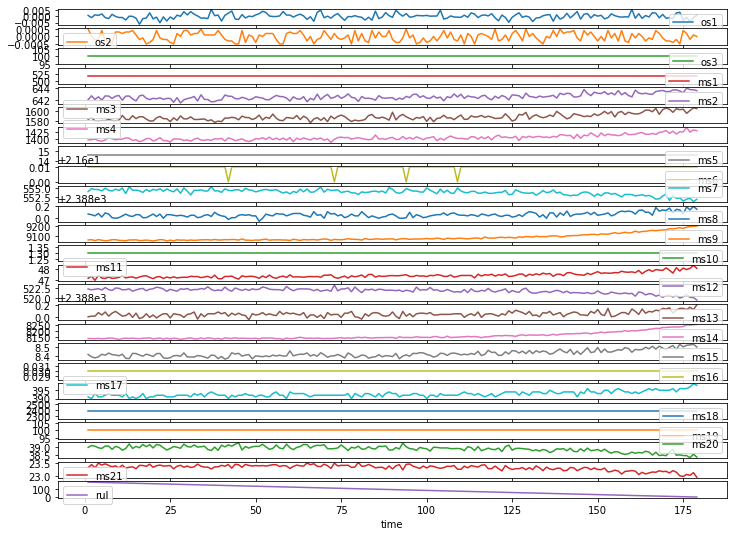

In [119]:
plot_cols = ['os1', 'os2', 'os3', 'ms1', 'ms2', 'ms3', 'ms4', 'ms5', 'ms6','ms7','ms8', 
  'ms9', 'ms10', 'ms11', 'ms12', 'ms13', 'ms14', 'ms15', 'ms16', 'ms17', 'ms18', 'ms19', 'ms20', 'ms21', 'rul']
plot_features = train_df[(train_df['unit']==3) & (train_df['file']==1)][plot_cols]
plot_features.index = train_df[(train_df['unit']==3) & (train_df['file']==1)]['time']
_ = plot_features.plot(subplots=True)

It looks like as the machine approaches failure measurements like ms2, ms3, ms4, ms8, ms9, ms11, ms14, ms15 and ms16 start to increase and ms7, ms12, ms20 and ms21 start to decrease. The linear drop in remaining useful life (RUL) is in the bottom plot.

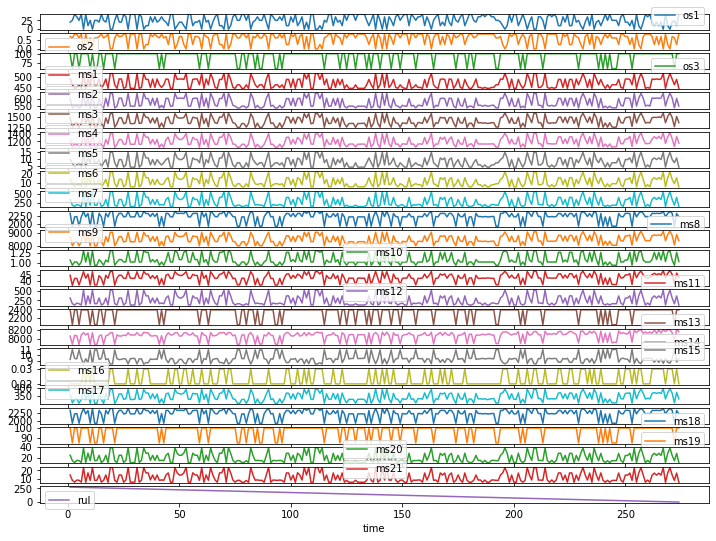

In [120]:
plot_features = train_df[(train_df['unit']==4) & (train_df['file']==4)][plot_cols]
plot_features.index = train_df[(train_df['unit']==4) & (train_df['file']==4)]['time']
_ = plot_features.plot(subplots=True)

For files 2 and 4 where the conditions are not sea level, it looks like the failing pattern is not apparent.

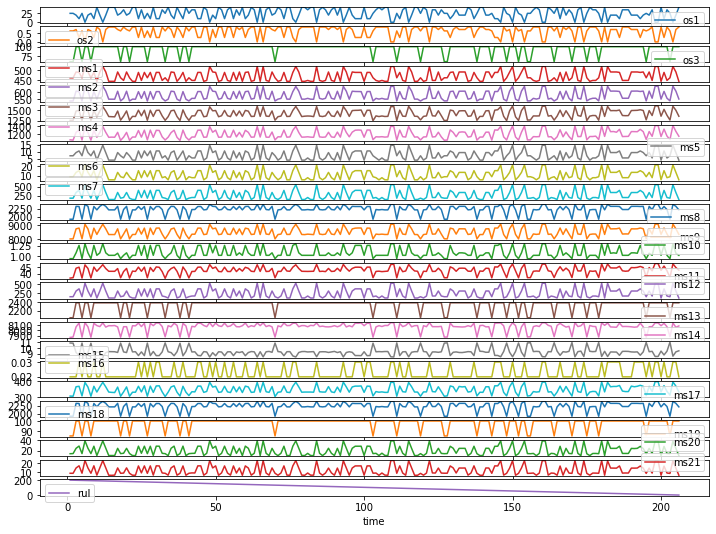

In [121]:
plot_features = train_df[(train_df['unit']==3) & (train_df['file']==2)][plot_cols]
plot_features.index = train_df[(train_df['unit']==3) & (train_df['file']==2)]['time']
_ = plot_features.plot(subplots=True)

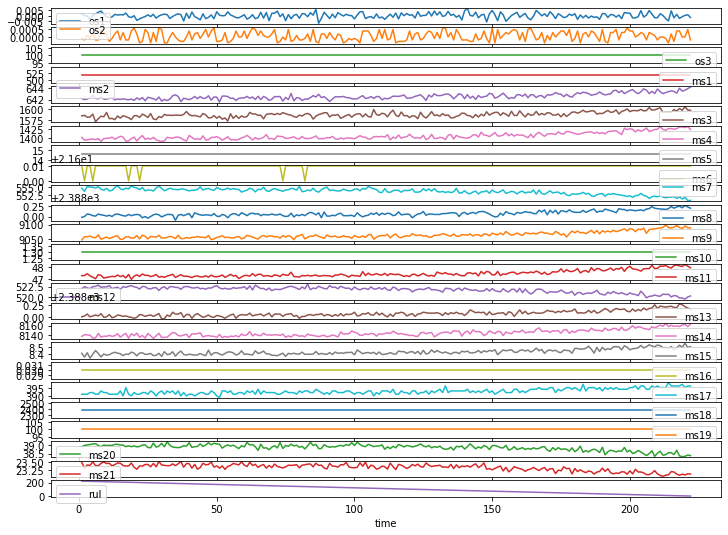

In [122]:
plot_features = train_df[(train_df['unit']==3) & (train_df['file']==3)][plot_cols]
plot_features.index = train_df[(train_df['unit']==3) & (train_df['file']==3)]['time']
_ = plot_features.plot(subplots=True)

In [123]:
train_df[(train_df['file']==1)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
time,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
os1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
os2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
os3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
ms1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
ms2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
ms3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
ms4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
ms5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [124]:
train_df[(train_df['file']==2)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,53759.0,131.082981,74.463862,1.0000,68.0000,131.0000,195.0000,260.0000
time,53759.0,109.154746,69.180569,1.0000,52.0000,104.0000,157.0000,378.0000
os1,53759.0,23.998407,14.747376,0.0000,10.0046,25.0013,41.9980,42.0080
os2,53759.0,0.572056,0.310016,0.0000,0.2507,0.7000,0.8400,0.8420
os3,53759.0,94.046020,14.237735,60.0000,100.0000,100.0000,100.0000,100.0000
ms1,53759.0,472.910207,26.389707,445.0000,445.0000,462.5400,491.1900,518.6700
ms2,53759.0,579.672399,37.289399,535.5300,549.5700,555.9800,607.3400,644.5200
ms3,53759.0,1419.971013,105.946341,1243.7300,1352.7600,1369.1800,1499.3700,1612.8800
ms4,53759.0,1205.442024,119.123428,1023.7700,1123.6550,1138.8900,1306.8500,1439.2300
ms5,53759.0,8.031986,3.613839,3.9100,3.9100,7.0500,10.5200,14.6200


In [125]:
train_df[(train_df['file']==3)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,24720.0,48.631877,2.934899e+01,1.0000,23.0000,47.0000,74.0000,100.0000
time,24720.0,139.077063,9.884668e+01,1.0000,62.0000,124.0000,191.0000,525.0000
os1,24720.0,-0.000024,2.193545e-03,-0.0086,-0.0015,-0.0000,0.0015,0.0086
os2,24720.0,0.000005,2.940429e-04,-0.0006,-0.0002,-0.0000,0.0003,0.0007
os3,24720.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
ms1,24720.0,518.670000,6.684921e-11,518.6700,518.6700,518.6700,518.6700,518.6700
ms2,24720.0,642.457858,5.230311e-01,640.8400,642.0800,642.4000,642.7900,645.1100
ms3,24720.0,1588.079175,6.810418e+00,1564.3000,1583.2800,1587.5200,1592.4125,1615.3900
ms4,24720.0,1404.471212,9.773178e+00,1377.0600,1397.1875,1402.9100,1410.6000,1441.1600
ms5,24720.0,14.620000,3.602525e-12,14.6200,14.6200,14.6200,14.6200,14.6200


In [126]:
train_df[(train_df['file']==4)].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,61249.0,124.325181,71.995350,1.0000,60.0000,126.0000,185.0000,249.0000
time,61249.0,134.311417,89.783389,1.0000,62.0000,123.0000,191.0000,543.0000
os1,61249.0,23.999823,14.780722,0.0000,10.0046,25.0014,41.9981,42.0080
os2,61249.0,0.571347,0.310703,0.0000,0.2507,0.7000,0.8400,0.8420
os3,61249.0,94.031576,14.251954,60.0000,100.0000,100.0000,100.0000,100.0000
ms1,61249.0,472.882435,26.436832,445.0000,445.0000,462.5400,491.1900,518.6700
ms2,61249.0,579.420056,37.342647,535.4800,549.3300,555.7400,607.0700,644.4200
ms3,61249.0,1417.896600,106.167598,1242.6700,1350.5500,1367.6800,1497.4200,1613.0000
ms4,61249.0,1201.915359,119.327591,1024.4200,1119.4900,1136.9200,1302.6200,1440.7700
ms5,61249.0,8.031626,3.622872,3.9100,3.9100,7.0500,10.5200,14.6200


In [132]:
train1_df = train_df[(train_df['unit']==3) & (train_df['file']==3)].drop(columns=['unit','time','conditions','file']).astype(np.float32)
val1_df = train_df[(train_df['unit']==4) & (train_df['file']==3)].drop(columns=['unit','time','conditions','file']).astype(np.float32)
test1_df = train_df[(train_df['unit']==5) & (train_df['file']==3)].drop(columns=['unit','time','conditions','file']).astype(np.float32)

The data that feeds LSTM need to be transformed into windows. Here we take advantage of the 
 [TensorFlow](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network) code to generate our own windows that we will feed into the model. There is no point reinventing the wheel!

In [133]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train1_df, val_df=val1_df, test_df=test1_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [134]:
window = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['rul'])
window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['rul']

In [135]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [138]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train1_df[:window.total_window_size]),
                           np.array(train1_df[100:100+window.total_window_size]),
                           np.array(train1_df[200:200+window.total_window_size])])

example_inputs, example_labels = window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 1, 1)


In [141]:
example_window

<tf.Tensor: shape=(3, 7, 25), dtype=float32, numpy=
array([[[ 1.80000e-03, -1.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42190e+02,  1.58549e+03,  1.40155e+03,  1.46200e+01,
          2.16100e+01,  5.54670e+02,  2.38798e+03,  9.04611e+03,
          1.30000e+00,  4.72900e+01,  5.21920e+02,  2.38800e+03,
          8.13614e+03,  8.41110e+00,  3.00000e-02,  3.91000e+02,
          2.38800e+03,  1.00000e+02,  3.89100e+01,  2.34896e+01,
          2.21000e+02],
        [ 3.00000e-04, -2.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42000e+02,  1.58660e+03,  1.39399e+03,  1.46200e+01,
          2.16000e+01,  5.53730e+02,  2.38800e+03,  9.05738e+03,
          1.30000e+00,  4.73000e+01,  5.22480e+02,  2.38802e+03,
          8.13991e+03,  8.35940e+00,  3.00000e-02,  3.91000e+02,
          2.38800e+03,  1.00000e+02,  3.90000e+01,  2.32964e+01,
          2.20000e+02],
        [-2.00000e-04,  1.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42100e+02,  1.58243e+03,  1.39489e+03,  1.4

In [140]:
example_inputs

<tf.Tensor: shape=(3, 6, 25), dtype=float32, numpy=
array([[[ 1.80000e-03, -1.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42190e+02,  1.58549e+03,  1.40155e+03,  1.46200e+01,
          2.16100e+01,  5.54670e+02,  2.38798e+03,  9.04611e+03,
          1.30000e+00,  4.72900e+01,  5.21920e+02,  2.38800e+03,
          8.13614e+03,  8.41110e+00,  3.00000e-02,  3.91000e+02,
          2.38800e+03,  1.00000e+02,  3.89100e+01,  2.34896e+01,
          2.21000e+02],
        [ 3.00000e-04, -2.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42000e+02,  1.58660e+03,  1.39399e+03,  1.46200e+01,
          2.16000e+01,  5.53730e+02,  2.38800e+03,  9.05738e+03,
          1.30000e+00,  4.73000e+01,  5.22480e+02,  2.38802e+03,
          8.13991e+03,  8.35940e+00,  3.00000e-02,  3.91000e+02,
          2.38800e+03,  1.00000e+02,  3.90000e+01,  2.32964e+01,
          2.20000e+02],
        [-2.00000e-04,  1.00000e-04,  1.00000e+02,  5.18670e+02,
          6.42100e+02,  1.58243e+03,  1.39489e+03,  1.4

In [139]:
example_labels

<tf.Tensor: shape=(3, 1, 1), dtype=float32, numpy=
array([[[215.]],

       [[115.]],

       [[ 15.]]], dtype=float32)>

In [142]:
window.example = example_inputs, example_labels

In [143]:
def plot(self, model=None, plot_col='rul', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

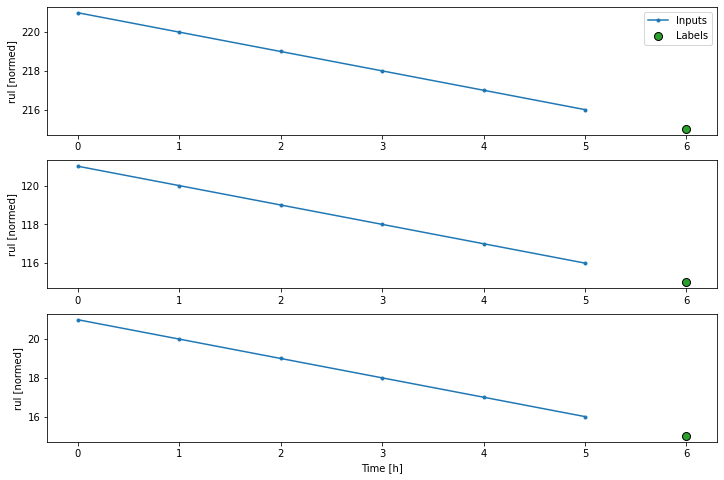

In [145]:
window.plot()

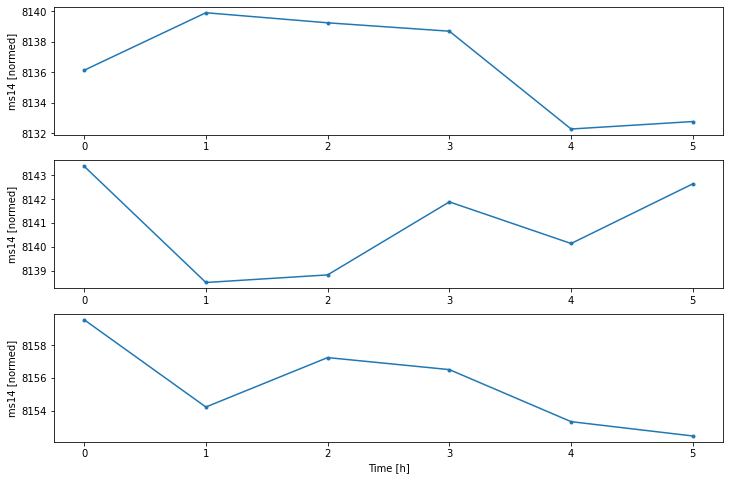

In [147]:
window.plot(plot_col='ms14')

In [148]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [149]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [150]:
# Each element is an (inputs, label) pair.
window.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [151]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 25)
Labels shape (batch, time, features): (32, 1, 1)


Configuring LSTMs is not a trivial task! As we saw, we went through really complicated procedures to prepare the data. In addition to how complicated LSTMs are, there is always TensorFlow! However, from here, it's just a matter of training the models and the beauty of ML manifests!

In [156]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [152]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [154]:
print('Input shape:', window.example[0].shape)
print('Output shape:', lstm_model(window.example[0]).shape)

Input shape: (32, 6, 25)
Output shape: (32, 6, 1)


In [157]:
history = compile_and_fit(lstm_model, window)

IPython.display.clear_output()
val_performance_LSTM = lstm_model.evaluate(window.val)
performance_LSTM = lstm_model.evaluate(window.test, verbose=0)

9/9 [==============================] - 0s 4ms/step - loss: 23157.5762 - mean_absolute_error: 131.3917


ValueError: x and y must be the same size

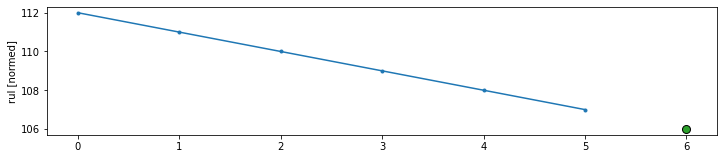

In [158]:
window.plot(lstm_model)